In [16]:
from PIL import Image, ImageFont, ImageDraw, ImageOps
import numpy as np
from matplotlib import pyplot as plt
import csv

In [17]:
string = '𐎀𐎁𐎂𐎃𐎄𐎅𐎆𐎇𐎈𐎉𐎊𐎋𐎌𐎍𐎎𐎏𐎐𐎑𐎒𐎓𐎔𐎕𐎖𐎗𐎘𐎙𐎚𐎛𐎜𐎝'.upper()
alphabet = []
for letter in string:
    alphabet.append(letter)
print(alphabet)

['𐎀', '𐎁', '𐎂', '𐎃', '𐎄', '𐎅', '𐎆', '𐎇', '𐎈', '𐎉', '𐎊', '𐎋', '𐎌', '𐎍', '𐎎', '𐎏', '𐎐', '𐎑', '𐎒', '𐎓', '𐎔', '𐎕', '𐎖', '𐎗', '𐎘', '𐎙', '𐎚', '𐎛', '𐎜', '𐎝']


In [18]:
def simple_binarization(image, threshold):  #просто функция для бинаризации 
    img_arr = np.array(image)
    new_image = np.zeros(shape=img_arr.shape)
    new_image[img_arr > threshold] = 255
    return Image.fromarray(new_image.astype(np.uint8), 'L')

In [19]:
def cut_empty_rows_and_cols(image):

    empty_row_numbers = []
    empty_column_numbers = []

    for x in range(image.width): #ищем пустые строки и столбцы 
        is_col_empty = True
        for y in range(image.height):
            if image.getpixel((x, y)) < 255:
                is_col_empty = False
                break

        if is_col_empty:
            empty_column_numbers.append(x)

    for y in range(image.height):
        is_row_empty = True
        for x in range(image.width):
            if image.getpixel((x, y)) < 255:
                is_row_empty = False
                break

        if is_row_empty:
            empty_row_numbers.append(y)

    def last_element_in_a_row(elements, start_element, step):  #определяем края обрезки
        prev_element = start_element

        for element in elements[::step]:
            if abs(element - prev_element) > 1:
                return prev_element + step

            prev_element = element

        return prev_element + step

    left_whitespace_end = last_element_in_a_row(empty_column_numbers, -1, 1)
    upper_whitespace_end = last_element_in_a_row(empty_row_numbers, -1, 1)
    right_whitespace_end = last_element_in_a_row(empty_column_numbers, image.width, -1)
    lower_whitespace_end = last_element_in_a_row(empty_row_numbers, image.height, -1)

    return image.crop(box=(left_whitespace_end, upper_whitespace_end, right_whitespace_end + 1, lower_whitespace_end + 1)) #обрезаем пустоту, оставляя просто прямоугольник

In [20]:
def color_used_arr(img):  #преобразование в двумерный массив, где 1 - черный символ а 0 белый фон
    return np.asarray(np.asarray(img) < 1, dtype = np.int0)

In [21]:
def get_profiles(img):
    img_arr_for_calculations = color_used_arr(img)
    
    x_profiles = np.sum(img_arr_for_calculations, axis=0)
    x_range = np.arange(1, img_arr_for_calculations.shape[1] + 1)
    
    y_profiles = np.sum(img_arr_for_calculations, axis=1)
    y_range = np.arange(1, img_arr_for_calculations.shape[0] + 1)  #суммирование черных по осям для получения профилей и их диапазонов значений
    
    return {
        'x_profiles': x_profiles,
        'x_range': x_range,
        'y_profiles': y_profiles,
        'y_range': y_range
    }

In [22]:
def show_profiles_x(img):
    profiles = get_profiles(img)
    plt.figure(figsize=(12,2))
    plt.bar(x=profiles['x_range'], height=profiles['x_profiles'], width=0.85)
    plt.ylim(0, max(profiles['x_profiles']))
    plt.xlim(0, max(profiles['x_range']))
    plt.show()

def show_profiles_y(img):
    profiles = get_profiles(img)
    plt.figure(figsize=(12,2))
    plt.barh(y=profiles['y_range'], width=profiles['y_profiles'], height=0.85)
    plt.ylim(max(profiles['y_range']), 0 ) #img.size[1], 0)
    plt.xlim(0, max(profiles['y_profiles']))
    plt.show()

In [23]:
def get_segments_list(img):
    img_arr_for_calculations = color_used_arr(img)
    x_profiles = np.sum(img_arr_for_calculations, axis=0)
    lst = [] #индексы где нет черных пикселей
    new_lst = []  #начало и конец сегментов
    for i in range(len(x_profiles)):  #заполняем где нет черных 
        if x_profiles[i] == 0:
            lst.append(i)
    lst.append(img.width)  #добавляем ширину изображения в конец списка для обозначения конца последнего сегмента

    #пары индексов, обозначающих начало и конец
    for i in range(len(lst)-1):
        if lst[i] + 1 != lst[i+1]:
            new_lst.append(lst[i])
            new_lst.append(lst[i+1])
    new_lst.append(img.width-1)
    new_lst = sorted(list(set(new_lst))) #убирем дубликаты и отсортируем список
    
    
    segments = []
    for i in range(0, len(new_lst)-1, 2):
        segments.append((new_lst[i], new_lst[i+1]))
    return segments

In [24]:
def result_draw(image, segments):
    left_color = (124,252,0)  #зеленый для левой
    right_color = (160,32,240) #фиолетовый цвет для правой границы
    result = image.copy().convert('RGB')
    result_draw = ImageDraw.Draw(im=result)
    for segment in segments:
        result_draw.rectangle(xy=[(segment[0], 0), (segment[0], result.height)], fill=left_color)
        result_draw.rectangle(xy=[(segment[1], 0), (segment[1], result.height)], fill=right_color)
    return result

In [25]:
font_size = 50
font = ImageFont.truetype("input/fonts/NotoSansUgaritic-Regular.ttf", font_size)

In [26]:
def generate_sentence():
    img = Image.new(mode="L", size=(2555, 150), color="white")
    draw = ImageDraw.Draw(img, mode = 'L')
    draw.text(xy=(0, 0), text='𐎎𐎏𐎐 𐎀𐎁𐎜𐎝 𐎋', fill=0, font=font, anchor = 'lt')
    cutted_img = cut_empty_rows_and_cols(img) #cut_white_image_parts(img)
    simple_binarization(cutted_img, 100).save('output/font_50_test.png')

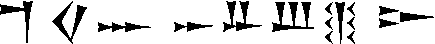

In [27]:
generate_sentence()
font_50_test_img = Image.open('font_50_test.png')
font_50_test_img

In [28]:
segments = get_segments_list(font_50_test_img)
segments

C:\Users\Kokovino\AppData\Local\Temp\ipykernel_15464\2461294313.py:2: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  return np.asarray(np.asarray(img) < 1, dtype = np.int0)


[(51, 87),
 (97, 151),
 (173, 213),
 (222, 262),
 (271, 314),
 (324, 333),
 (334, 345),
 (346, 355),
 (378, 399)]

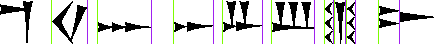

In [33]:
result = result_draw(font_50_test_img, segments)
result.save('output/result_font_50.png')
result

C:\Users\Kokovino\AppData\Local\Temp\ipykernel_15464\2461294313.py:2: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  return np.asarray(np.asarray(img) < 1, dtype = np.int0)


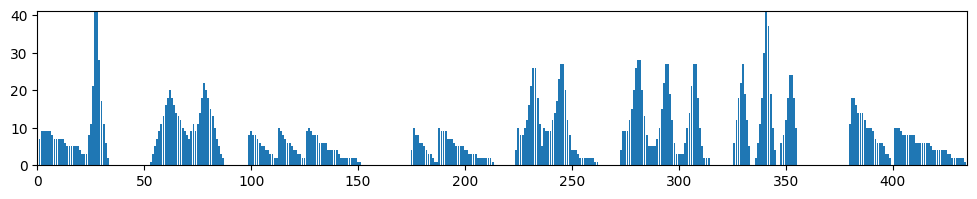

In [31]:
show_profiles_x(font_50_test_img)

C:\Users\Kokovino\AppData\Local\Temp\ipykernel_15464\2461294313.py:2: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  return np.asarray(np.asarray(img) < 1, dtype = np.int0)


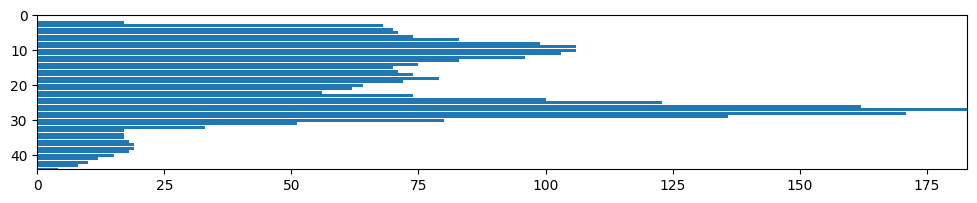

In [32]:
show_profiles_y(font_50_test_img)